## Стратегии, основанные на импульсе

Стратегии, основанные на импульсе, бывают двух типов (по крайней мере, всякие исследователи выделяют два типа таких стратегий)
1. Первый тип - так называеммые кросс-секциональные стратегии. Их суть - если из множества инструментов выбрать тот, который показывает лучший рост, то можно предположить, что этот рост продолжится. И этот инструмент надо покупать. И наоборот с продажей.
2. Второй тип - это стратегии, оставанные на временном ряде. В этом случае инструмент сравнивается не с другими инструментами в группе, а сам с собой некоторое время назад. ТО есть если инструмент растет, то можно предположить, что он и дальше будет расти, следовательно покупаем. И, наоборот, с продажей.

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
from pylab import mpl, plt
import seaborn as sns

In [2]:
datafile = '/home/sash/Python/projects/mlfin/data/XAUUSD_Daily_201101020000_202110130000.csv'
data = pd.read_csv(datafile,
                 encoding='utf-8',
                 index_col=0,
                 skiprows=1,
                 header= None,
                 parse_dates=True,
                 names= ['open','high', 'low', 'close', 'tv', 'vol', 'spread'],
                 sep='\t')
data = pd.DataFrame(data['close'])
data.rename(columns = {'close': 'price'}, inplace=True)
data['returns'] = np.log(data['price']/data['price'].shift(1))

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3317 entries, 2011-01-02 to 2021-10-13
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   price    3317 non-null   float64
 1   returns  3316 non-null   float64
dtypes: float64(2)
memory usage: 77.7 KB


In [4]:
# Определим новый столбец через np.sign(), который
# принимает значения -1, если 'returns' < 0, и 1,
# если 'returns' > 0

data['position'] = np.sign(data['returns'])

In [5]:
# Рассчитаем логарифмическую доходность с учетом
# открытых позиций
data['strategy'] = data['position'].shift(1) * data['returns']

<AxesSubplot:>

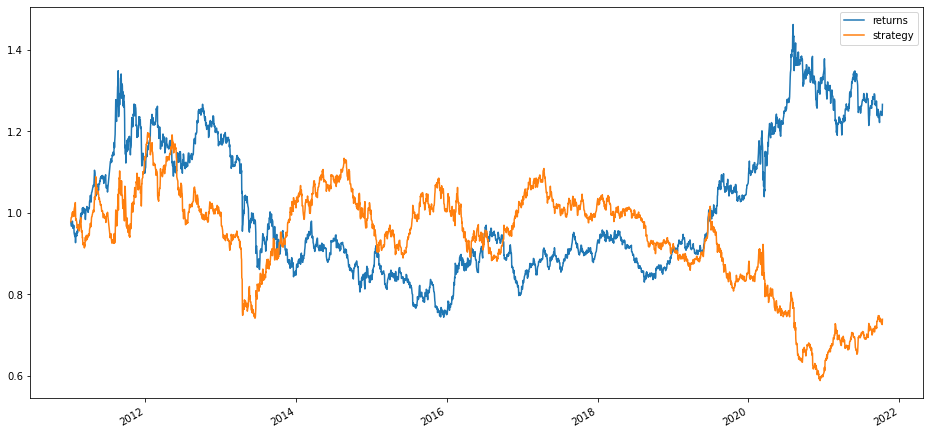

In [6]:
# Построим графики и сравним стратегию с эталонным инструментом
data[['returns', 'strategy']].dropna().cumsum(
).apply(np.exp).plot(figsize=(16, 8))

<AxesSubplot:>

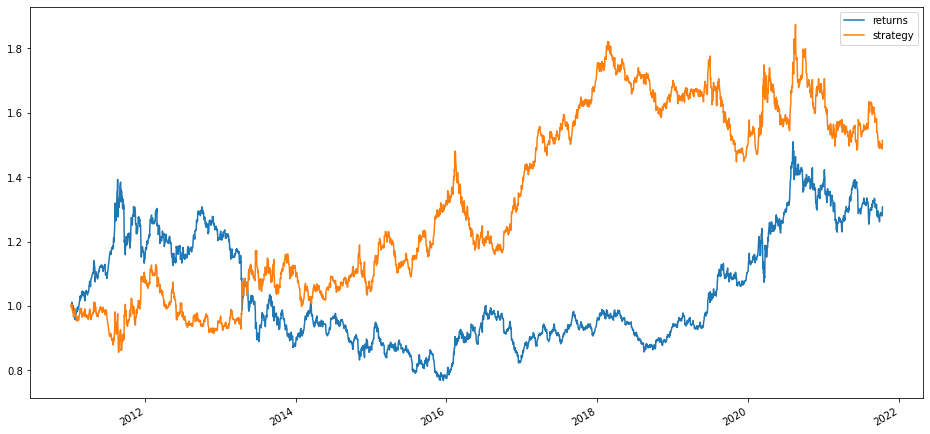

In [7]:
# Используя скользящую среднюю, стратегию можно 
# распространить не только на последнюю доходность, 
# а на три последних доходности. В этом случае 
# результативность стратегии возрастает
data['position'] = np.sign(data['returns'].rolling(4).mean())
data['strategy'] = data['position'].shift(1) * data['returns']
data[['returns', 'strategy']].dropna().cumsum(
    ).apply(np.exp).plot(figsize=(16, 8))

Система довольно чувствительна к величине окна. На скользящем окне в 2 периода производительность чувствительно падает. (стр 185)

Согласно теории в книге, внутридневная импульсная торговля должна быть не менее эффективна, чем дневная. Как раз сечас попробую на искусственных индексах Deriv, попробую 10V и 100V, часовики. Собственно, потом можно и AAPL на часовиках проверить. Поехали.

In [8]:
# Загружаем данные и рассчитываем почасовую доходность
datafile = '/home/sash/Python/projects/mlfin/data/Volatility 10 Index_H1_201901010500_202109010000.csv'
data = pd.read_csv(datafile,
                 encoding='utf-8',
                 index_col=False,
                 skiprows=1,
                 header= None,
                 names= ['date', 'time','open','high', 'low', 'close', 'tv', 'vol', 'spread'],
                 sep='\t')
data['datetime'] = data['date'] + ' ' + data['time']

data.reset_index(drop=True, inplace=True)
data = data.set_index('datetime')


data = pd.DataFrame(data['close'])
data.rename(columns = {'close': 'price'}, inplace=True)
data['returns'] = np.log(data['price']/data['price'].shift(1))

In [9]:
data.head()

,price,returns
datetime,,
2019.01.01 05:00:00,7985.697,NaN
2019.01.01 06:00:00,7985.746,0.000006
2019.01.01 07:00:00,7985.078,-0.000084
2019.01.01 08:00:00,7989.836,0.000596
2019.01.01 09:00:00,7985.492,-0.000544


In [10]:
# Определяем список для столбцов, которые будут построены
# позже

to_plot = ['returns']

In [11]:
for m in [1, 2, 3, 4, 5]:
    # Рассчитывает позиции в соответствии с параметром средней
    data['position_%d' %m] = np.sign(
        data['returns'].rolling(m).mean())
    # Рассчитываем логарифмическую доходность стратегий
    data['strategy_%d' %m] = (
        data['position_%d' %m].shift(1) * data['returns'])
    # Добавляем имя столбца в список для построения 
    # графика в дальнейшем
    to_plot.append('strategy_%d' %m)
    


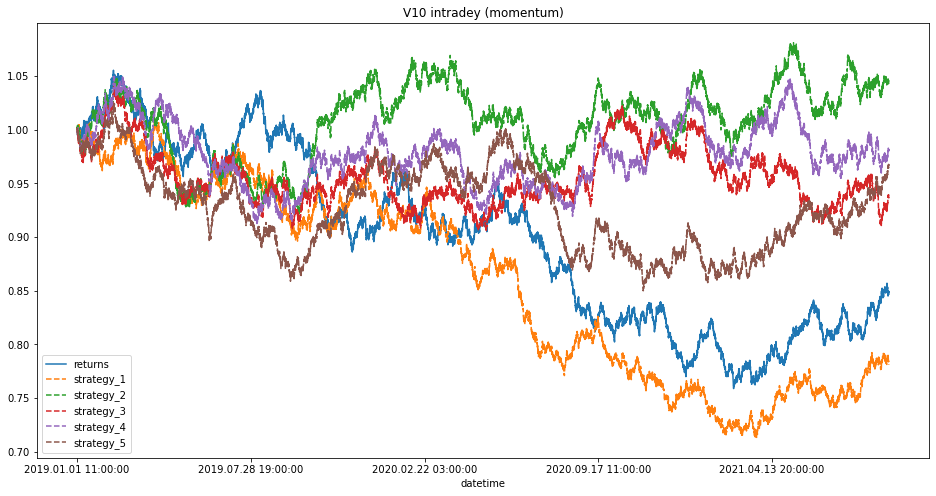

In [12]:
# Строим на графике все варианты стратегии в сравнении 
# с эталонным активом
data[to_plot].dropna().cumsum().apply(np.exp).plot(
    title='V10 intradey (momentum)',
    figsize=(16, 8),
    style=['-', '--', '--', '--', '--', '--']);

Так себе на V10. Посмотрим на V100

In [13]:
# Загружаем данные и рассчитываем почасовую доходность
datafile = '/home/sash/Python/projects/mlfin/data/Volatility 100 Index_H1_201901010500_202110140900.csv'
data = pd.read_csv(datafile,
                 encoding='utf-8',
                 index_col=False,
                 skiprows=1,
                 header= None,
                 names= ['date', 'time','open','high', 'low', 'close', 'tv', 'vol', 'spread'],
                 sep='\t')
data['datetime'] = data['date'] + ' ' + data['time']

data.reset_index(drop=True, inplace=True)
data = data.set_index('datetime')


data = pd.DataFrame(data['close'])
data.rename(columns = {'close': 'price'}, inplace=True)
data['returns'] = np.log(data['price']/data['price'].shift(1))

In [14]:
# Определяем список для столбцов, которые будут построены
# позже

to_plot = ['returns']

In [15]:
for m in [1, 2, 3, 4, 5]:
    # Рассчитывает позиции в соответствии с параметром средней
    data['position_%d' %m] = np.sign(
        data['returns'].rolling(m).mean())
    # Рассчитываем логарифмическую доходность стратегий
    data['strategy_%d' %m] = (
        data['position_%d' %m].shift(1) * data['returns'])
    # Добавляем имя столбца в список для построения 
    # графика в дальнейшем
    to_plot.append('strategy_%d' %m)
   

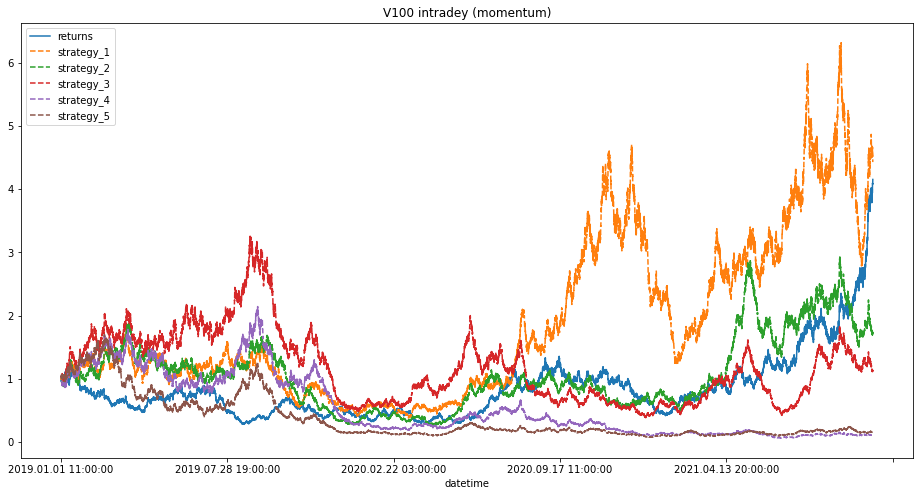

In [16]:
# Строим на графике все варианты стратегии в сравнении 
# с эталонным активом
data[to_plot].dropna().cumsum().apply(np.exp).plot(
    title='V100 intradey (momentum)',
    figsize=(16, 8),
    style=['-', '--', '--', '--', '--', '--']);

А вот это уже интересно. Конечно, переход от 1 к 2-ке весьма резок, колбасит стратегии по-взрослому. Интересно, что было в 2019 и начале 2021, когда просадки по всем стратегиям.. Но, блин, 500% доходности. 

Попробуем с AAPL интрадей. 

In [17]:
# Загружаем данные и рассчитываем почасовую доходность
datafile = '/home/sash/Python/projects/mlfin/data/AAPL_H1_201912021400_202110131900.csv'
data = pd.read_csv(datafile,
                 encoding='utf-8',
                 index_col=False,
                 skiprows=1,
                 header= None,
                 names= ['date', 'time','open','high', 'low', 'close', 'tv', 'vol', 'spread'],
                 sep='\t')
data['datetime'] = data['date'] + ' ' + data['time']

data.reset_index(drop=True, inplace=True)
data = data.set_index('datetime')


data = pd.DataFrame(data['close'])[1484:]
data.rename(columns = {'close': 'price'}, inplace=True)
data['returns'] = np.log(data['price']/data['price'].shift(1))

In [18]:
# Определяем список для столбцов, которые будут построены
# позже

to_plot = ['returns']

In [19]:
for m in [1, 5, 7, 9, 11]:
    # Рассчитывает позиции в соответствии с параметром средней
    data['position_%d' %m] = np.sign(
        data['returns'].rolling(m).mean())
    # Рассчитываем логарифмическую доходность стратегий
    data['strategy_%d' %m] = (
        data['position_%d' %m].shift(1) * data['returns'])
    # Добавляем имя столбца в список для построения 
    # графика в дальнейшем
    to_plot.append('strategy_%d' %m)
   

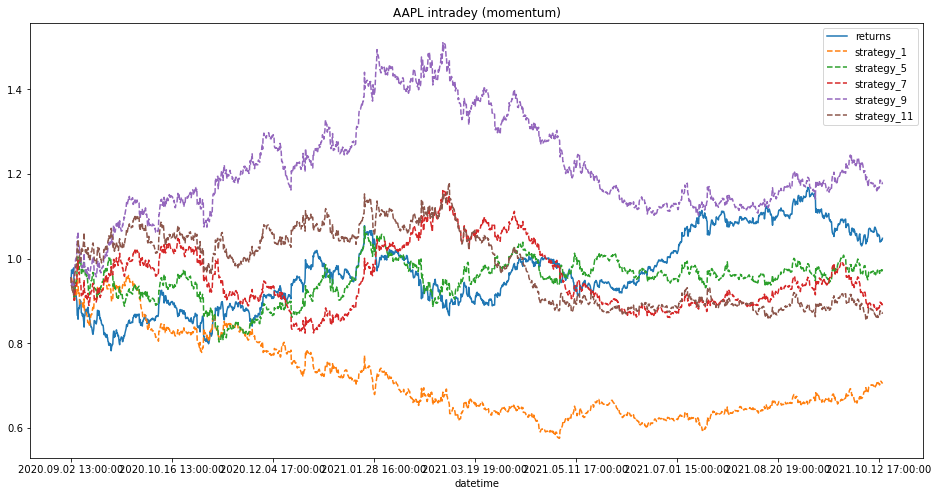

In [20]:
# Строим на графике все варианты стратегии в сравнении 
# с эталонным активом
data[to_plot].dropna().cumsum().apply(np.exp).plot(
    title='AAPL intradey (momentum)',
    figsize=(16, 8),
    style=['-', '--', '--', '--', '--', '--']);

Мда уж, данные по акциям на Deriv хороши... :(

![картинка](/home/sash/Python/projects/mlfin/data/imaages/AAPL_data_Deriv.png)
Картина маслом

Посмотрим на EURUSD

In [21]:
# Загружаем данные и рассчитываем почасовую доходность
datafile = '/home/sash/Python/projects/mlfin/data/EURUSD_H1_201001032200_202110141100.csv'
data = pd.read_csv(datafile,
                 encoding='utf-8',
                 index_col=False,
                 skiprows=1,
                 header= None,
                 names= ['date', 'time','open','high', 'low', 'close', 'tv', 'vol', 'spread'],
                 sep='\t')
data['datetime'] = data['date'] + ' ' + data['time']

data.reset_index(drop=True, inplace=True)
data = data.set_index('datetime')


data = pd.DataFrame(data['close'])
data.rename(columns = {'close': 'price'}, inplace=True)
data['returns'] = np.log(data['price']/data['price'].shift(1))

In [22]:
# Определяем список для столбцов, которые будут построены
# позже

to_plot = ['returns']

In [23]:
for m in [5, 7, 9, 11, 13, 24]:
    # Рассчитывает позиции в соответствии с параметром средней
    data['position_%d' %m] = np.sign(
        data['returns'].rolling(m).mean())
    # Рассчитываем логарифмическую доходность стратегий
    data['strategy_%d' %m] = (
        data['position_%d' %m].shift(1) * data['returns'])
    # Добавляем имя столбца в список для построения 
    # графика в дальнейшем
    to_plot.append('strategy_%d' %m)
   

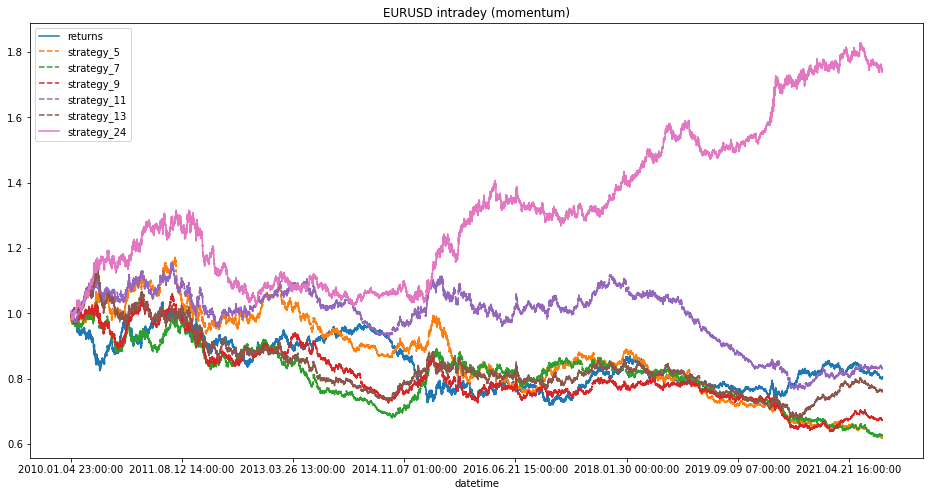

In [24]:
# Строим на графике все варианты стратегии в сравнении 
# с эталонным активом
data[to_plot].dropna().cumsum().apply(np.exp).plot(
    title='EURUSD intradey (momentum)',
    figsize=(16, 8),
    style=['-', '--', '--', '--', '--', '--']);

Интересно. При часовиках евры средние с периодом до 10 при этой стратегии можно не рассматривать. А вот при периоде 24 уже получается что-то интересное. Хотя в книжке интересно уже при периоде =3. гм. Посмотрим на бэктестере.

In [25]:
from Momentum_Backtesting import MomVectorBacktester as Mom

223344


In [26]:
filepath = '~/Python/projects/mlfin/data/EURUSD_Daily_201001030000_202110110000.csv'
mombt = Mom(filepath, '', '2010-01-03', '2019-12-31',False, 10000, 0.0)

In [29]:
mombt.run_strategy(momentum=24)

(9737.39, 1663.27)

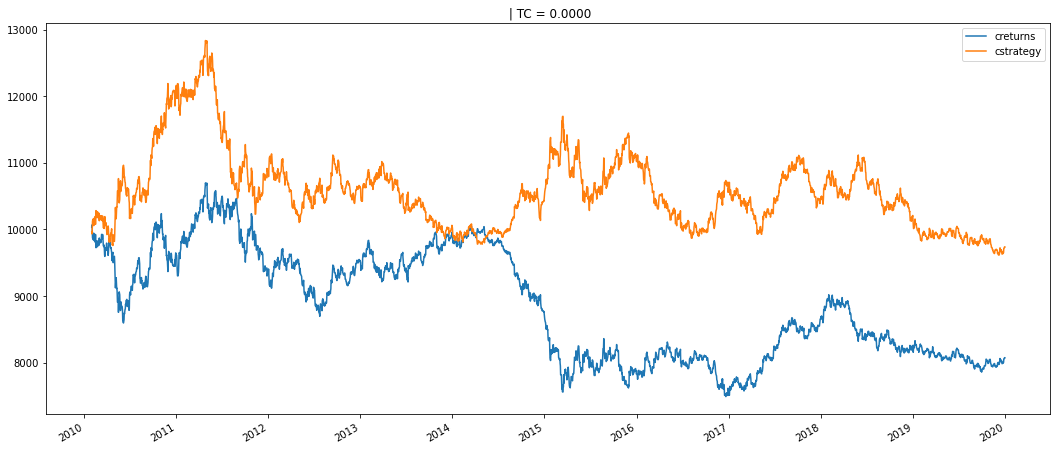

In [30]:
mombt.plot_results()

In [31]:
filepath = '~/Python/projects/mlfin/data/EURUSD_Daily_201001030000_202110110000.csv'
mombt = Mom(filepath, 'EURUSD_D', '2010-01-03', '2019-12-31',False, 10000, 0.001)

In [32]:
mombt.run_strategy(momentum=24)

(7425.9, -648.23)

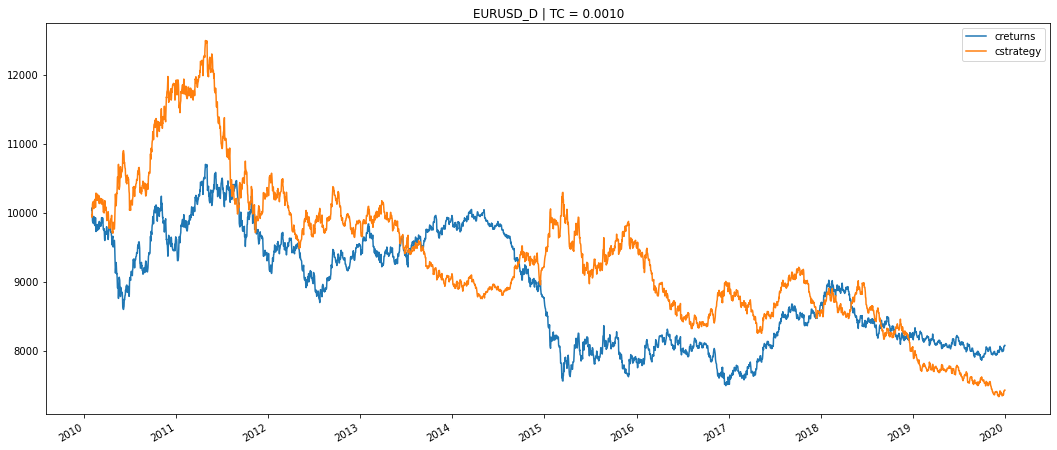

In [33]:
mombt.plot_results()